# 1. Importing Packages and Data

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from kneed import KneeLocator

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split


# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

In [2]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')


df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,30.0,38.0,4.0,7.0,13.0,20.0,81.0,7.0,99.6,105.2,91.2,94.9,8.4,10.3,0.483,1.08,13.5,0.317,0.696,0.517,15.978,16.9,0.478,0.530,1.0,0.201,81.26,77.5,64.58,77.0,0.542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,30.0,43.0,3.0,2.0,11.0,18.0,86.0,-9.0,100.7,107.5,119.7,117.3,-19.1,-9.8,0.484,1.25,13.2,0.383,0.696,0.538,14.045,15.0,0.467,0.497,1.0,0.197,82.40,80.5,67.08,80.0,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,26.0,42.0,7.0,11.0,11.0,20.0,95.0,-1.0,105.4,108.0,107.6,109.1,-2.2,-1.1,0.459,1.42,13.8,0.438,0.571,0.505,13.316,13.6,0.452,0.505,1.0,0.198,81.22,79.7,66.42,88.0,0.557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,34.0,47.0,13.0,6.0,3.0,22.0,102.0,31.0,111.9,117.2,82.0,80.7,29.9,36.6,0.561,5.75,18.1,0.327,0.714,0.515,4.390,4.6,0.467,0.509,1.0,0.196,88.84,87.5,72.92,87.0,0.736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,27.0,44.0,12.0,10.0,11.0,18.0,96.0,17.0,109.7,115.7,94.3,95.2,15.5,20.5,0.550,1.83,17.4,0.429,0.683,0.544,13.717,14.5,0.488,0.519,1.0,0.193,85.64,83.0,69.17,83.0,0.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


## 1.2 Filtering down df

So we discovered that many of the columns (like `touches`,`passes`,`assists`, etc) have a 0 for games prior the `2013-14` season. It is likely that those stats were not being tracked then but have elected to do the following (intentionally overwriting `df`):
- keep only regular and playoff games
- keep games from `2013-14` season and onward

Instead of utilitzing the `is_playoff_game` and `is_regular_game` (because of prior inconsistencies) we will be creating a termporary string version of `game_id` to use in the filtering

In [3]:
shape_before = df.shape

df['game_id_2'] = df['game_id'].astype('string')
df = df[(df.game_id_2.str.startswith('2', na=False)) | (df.game_id_2.str.startswith('4', na=False))]

print(f'Shape before: {shape_before}\n Shape after concat regular and playoff: {df.shape}')

Shape before: (55314, 72)
 Shape after concat regular and playoff: (51420, 73)


The following function should add an indicator column for simple subset of games past `2013-14` season

In [4]:
def has_acceptable_season(row):
    acceptable_seasons = [
        '2013-14',
        '2014-15',
        '2015-16',
        '2016-17',
        '2017-18',
        '2018-19',
        '2019-20',
        '2020-21',
        '2021-22',
        '2022-23',
        '2023-24'
    ]
    if row['season'] in acceptable_seasons:
        return 1
    else:
        return 0

Using the function and subsetting for when `acceptable_season` == 1 results in the following

In [5]:
shape_before = df.shape

df['acceptable_season'] = df.apply(has_acceptable_season, axis=1)
df = df.loc[df['acceptable_season'] == 1]

print(f'Shape before filtering for acceptable_season: {shape_before}\n Shape after filtering for acceptable_season: {df.shape}')

Shape before filtering for acceptable_season: (51420, 73)
 Shape after filtering for acceptable_season: (28258, 74)


Dropping the `acceptable_season` and `game_id_2` columns since they were only created and needed for this section

In [6]:
df = df.drop(columns=['acceptable_season', 'game_id_2'], axis=1)

Quick change to exclude values where 0 in specific columns doesnt make sense

In [7]:
df = df.loc[(df.distance != 0) & (df.touches != 0)] 
# Future note: You can expand on this by using df.loc[(df.distance != 0) | (df.opponent_points != 0)] 

# 2. Preprocess data
Before running PCA we need to:
1. Drop obvious non numeric columns
2. Decide which and drop dummy variables
3. Handle missing values
4. Standardize the numeric features (since PCA works best with standardized data)  

**Step 1. Drop the obvious/non numeric columns**
- `game_id`
- `season`
- `team_id`
- `team_name`
- `tri_code`
- `team_slug`
- `minutes`: right now is a string like object





In [8]:
drop_cols1 = [
    'game_id',
    'season',
    'team_id',
    'team_name',
    'tri_code',
    'team_slug',
    'minutes'
]

df = df.drop(columns=drop_cols1, axis=1)

**Step 2. Decide and drop dummy variables**

Going to check the variance of each dummy variable since if the variance is close to 0 it wont really contribute much to PCA and can be dropped

In [9]:
df[['is_home_team', 'won_game', 'is_playoff_game', 'is_regular_game']].var()

is_home_team       0.250009
won_game           0.250009
is_playoff_game    0.061102
is_regular_game    0.061102
dtype: float64

Since .25 is the maximum variance possible for binary dummy variable we'll keep `is_home_team` and `won_game` and drop `is_playoff_game` and `is_regular_game`

In [10]:
drop_cols3 = [
    'is_playoff_game',
    'is_regular_game'
]

df = df.drop(columns=drop_cols3, axis=1)

At this point `df` should only have numeric colums and will be renamed to `df_num` 

In [11]:
df_num = df.select_dtypes(include=np.number)
assert list(df.columns) == list(df_num.columns)

In [12]:
df_num = df
df_num.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
12495,37.0,78.0,0.474,12.0,26.0,0.462,18.0,23.0,0.783,6.0,34.0,40.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,3.13,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
12496,32.0,71.0,0.451,9.0,22.0,0.409,13.0,20.0,0.650,6.0,21.0,27.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,1.00,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
12497,32.0,62.0,0.516,10.0,21.0,0.476,18.0,24.0,0.750,5.0,21.0,26.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,0.85,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
12498,36.0,82.0,0.439,12.0,26.0,0.462,12.0,20.0,0.600,11.0,26.0,37.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,2.36,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
12499,40.0,68.0,0.588,13.0,25.0,0.520,17.0,22.0,0.773,5.0,34.0,39.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,1.30,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1


**Step 3. Handle missing values**

A prior notebook somehwere has the code for why dropping instead of imputing is fine

In [13]:
df.isna().sum().divide(len(df)).sort_values(ascending=False)

turnover_ratio                0.000142
estimated_defensive_rating    0.000142
net_rating                    0.000142
assist_percentage             0.000142
assist_to_turnover            0.000142
                                ...   
blocks                        0.000000
turnovers                     0.000000
fouls_personal                0.000000
points                        0.000000
won_game                      0.000000
Length: 63, dtype: float64

In [14]:
shape_before = df_num.shape
df_num = df_num.dropna()

print(f'Shape before dropping nas: {shape_before}\n Shape after dropping nas: {df_num.shape}')

Shape before dropping nas: (28146, 63)
 Shape after dropping nas: (28140, 63)


**Step 4. Standardize numeric features**

We will be using `StandardScaler` from scikit learn for this ([docs link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler))



There is no conclusive opinion on whether or not to scale the binary dummy variables.

In [15]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# convert back to dataframe
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

# 3. PCA

## 3.1 Explained Variance Approach

In [16]:
pca = PCA()
pca.fit(df_scaled)

# compute the explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


# fund the number of components that explains at least some threshold of variance
threshold = 0.9
n_components_thresh = np.argmax(cumulative_variance >= threshold) + 1
n_components_thresh

19

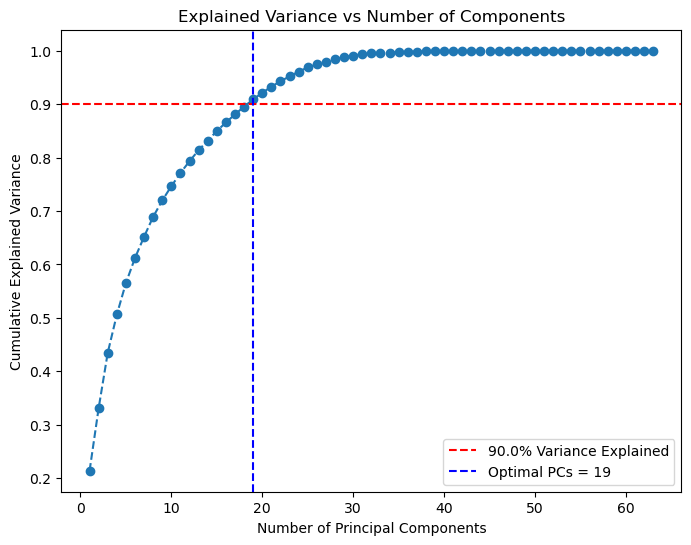

In [17]:
# plot the cumulative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1,len(cumulative_variance ) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Variance Explained')
plt.axvline(x=n_components_thresh, color='b', linestyle='--', label=f'Optimal PCs = {n_components_thresh}')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.legend()
plt.show()

## 3.2 Knee Locator Approach


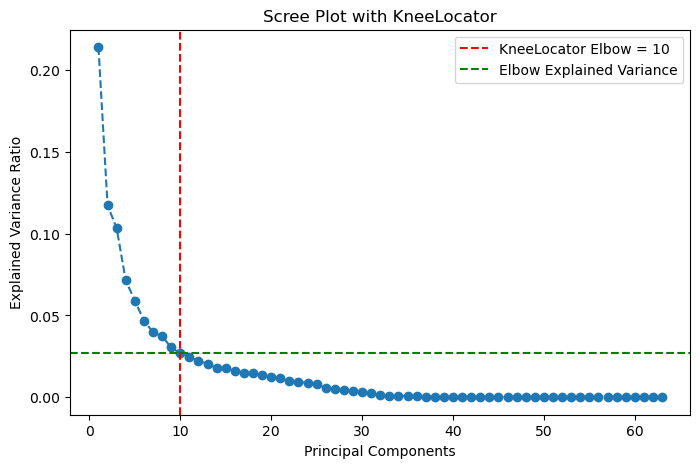

In [20]:

# Find the elbow point mathemetically
knee_locator = KneeLocator(range(1, len(explained_variance) + 1), explained_variance, curve='convex', direction='decreasing')
scree_components = knee_locator.knee

# scree plot with knee locator
plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained_variance ) + 1), explained_variance, marker='o', linestyle='--')
plt.axvline(x=scree_components, color='r', linestyle='--', label=f'KneeLocator Elbow = {scree_components}')
plt.axhline(y=explained_variance[scree_components-1], color='g', linestyle='--', label=f'Elbow Explained Variance')
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot with KneeLocator")
plt.legend()
plt.show()

In [21]:
# compare cumulative explained variance for both methods
exp_varScree = np.sum(explained_variance[:scree_components])
exp_varThresh = np.sum(explained_variance[:n_components_thresh])

print(f"Percentage of variance explained by {scree_components} components: {exp_varScree:.2%}")
print(f"Percentage of variance explained by {n_components_thresh} components: {exp_varThresh:.2%}")

Percentage of variance explained by 10 components: 74.67%
Percentage of variance explained by 19 components: 90.91%


## 3.3 Applying PCA and Finding influential variables

Using n_components determined by the explained variance method

In [38]:
# Conduct PCA using optimal number of components
model = PCA(n_components=n_components_thresh)
model.fit_transform(df_scaled)

array([[ 2.02317909, -3.8038841 , -2.67868964, ..., -0.84400442,
         0.85658912,  1.59481568],
       [-5.79955151,  2.22304356, -8.37780317, ..., -0.42921646,
         0.91185077,  1.61517228],
       [-2.97797515,  1.48215308, -8.22368808, ..., -0.75248137,
         1.33673049,  1.41098875],
       ...,
       [-2.40368813,  2.11872594,  2.56864622, ...,  0.81826446,
        -0.9167021 , -0.41419329],
       [-1.33908247,  2.54596687, -1.23975694, ...,  0.34681097,
        -0.33806916,  0.05473098],
       [-0.20049657, -2.20909634,  4.74082185, ...,  0.64130573,
        -0.49319477,  0.15596778]])

Determining influential variables by finding top n highest loading values from each component. The following function goes through each of the principal components and identifies the indices correlating with the top n loading values.

In [ ]:
model.components_.shape

In [22]:
from itertools import chain
# need itertools to flatten out the nested list in each row of top_n_features columns

def identify_important_features(model, col_names, n)->pd.DataFrame:
    """ 
    Returns a dataframe to identify the top n features from each principal component 
    """
    # number of components
    n_pcs = model.components_.shape[0]

    # find the top-n most important features for EACH component
    top_n_features = []
    for i in range(n_pcs):
        loadings = np.abs(model.components_[i])  # absolute value of loadings
        # 1) argpartition to get indices of the top n loadings (unsorted)
        topn_idx_unsorted = np.argpartition(loadings, -n)[-n:]
        # 2) sort those topn indices by actual loading value (descending)
        topn_idx_sorted = topn_idx_unsorted[np.argsort(-loadings[topn_idx_unsorted])]
        # 3) map indices to column names
        top_n = [col_names[idx] for idx in topn_idx_sorted]
        top_n_features.append(top_n)

    # build a dictionary: key=PC name, value=list of top-n feature names
    tmp = {"PC{}".format(i): top_n_features[i] for i in range(n_pcs)}

    # use the tmp dictionary to fill up a dataframe
    important_features_df = pd.DataFrame(tmp.items(), columns=['principal_component', 'top_n_features'])
    return important_features_df

So here are the identified important features when n=1

In [47]:
# goofy list set list usage to avoid seeing duplicate feature names
important_features_1 = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=1)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features_1))
important_features_1



15


['estimated_team_turnover_percentage',
 'opponent_points',
 'free_throws_percentage',
 'rebound_percentage',
 'effective_field_goal_percentage',
 'defended_at_rim_field_goals_attempted',
 'assist_percentage',
 'offensive_rebound_percentage',
 'is_home_team',
 'contested_field_goals_made',
 'steals',
 'possessions',
 'estimated_usage_percentage',
 'defensive_rebound_percentage',
 'free_throws_made']

These are the identified important features when n=2

In [48]:

important_features_2 = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=2)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features_2))
important_features_2



29


['rebounds_offensive',
 'passes',
 'free_throws_attempted',
 'defended_at_rim_field_goals_attempted',
 'estimated_defensive_rating',
 'defensive_rebound_percentage',
 'touches',
 'defended_at_rim_field_goals_made',
 'estimated_offensive_rating',
 'defended_at_rim_field_goal_percentage',
 'contested_field_goals_made',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'free_throws_percentage',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'assist_percentage',
 'rebound_chances_defensive',
 'three_pointers_made',
 'turnovers',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'rebound_percentage',
 'estimated_pace',
 'offensive_rebound_percentage',
 'is_home_team',
 'possessions']

These are the identified important features when n=3

In [ ]:

important_features_3 = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=3)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features_3))
important_features_3



29


['rebounds_offensive',
 'passes',
 'free_throws_attempted',
 'defended_at_rim_field_goals_attempted',
 'estimated_defensive_rating',
 'defensive_rebound_percentage',
 'touches',
 'defended_at_rim_field_goals_made',
 'estimated_offensive_rating',
 'defended_at_rim_field_goal_percentage',
 'contested_field_goals_made',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'free_throws_percentage',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'assist_percentage',
 'rebound_chances_defensive',
 'three_pointers_made',
 'turnovers',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'rebound_percentage',
 'estimated_pace',
 'offensive_rebound_percentage',
 'is_home_team',
 'possessions']

These are the identified important features when n=4

In [86]:

important_features_4 = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=4)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features_4))
important_features_4



46


['rebounds_offensive',
 'three_pointers_percentage',
 'passes',
 'free_throws_attempted',
 'defended_at_rim_field_goals_attempted',
 'uncontested_field_goals_attempted',
 'estimated_defensive_rating',
 'touches',
 'defensive_rebound_percentage',
 'uncontested_field_goals_percentage',
 'defended_at_rim_field_goals_made',
 'free_throw_assists',
 'pace_per40',
 'estimated_offensive_rating',
 'defended_at_rim_field_goal_percentage',
 'turnover_ratio',
 'contested_field_goals_made',
 'rebounds_defensive',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'free_throws_percentage',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'offensive_rating',
 'assist_percentage',
 'three_pointers_attempted',
 'rebound_chances_defensive',
 'three_pointers_made',
 'p_i_e',
 'turnovers',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'rebound_percentage',
 'blocks',
 'true_shooting_percentage',
 'estimated_pace',
 'assist_to_turnover',

These are the identified important features when n=5

In [88]:

important_features_5 = list(
    set(
        list(
            chain.from_iterable(
                identify_important_features(model=model,col_names=list(df_num.columns),n=5)['top_n_features'].to_list())
            )
        )
    )
print(len(important_features_5))
important_features_5



52


['rebounds_total',
 'rebounds_offensive',
 'three_pointers_percentage',
 'passes',
 'assist_ratio',
 'free_throws_attempted',
 'defended_at_rim_field_goals_attempted',
 'uncontested_field_goals_attempted',
 'field_goals_attempted',
 'estimated_defensive_rating',
 'touches',
 'defensive_rebound_percentage',
 'uncontested_field_goals_percentage',
 'defended_at_rim_field_goals_made',
 'free_throw_assists',
 'pace_per40',
 'plus_minus_points',
 'estimated_offensive_rating',
 'defended_at_rim_field_goal_percentage',
 'turnover_ratio',
 'contested_field_goals_made',
 'rebounds_defensive',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'free_throws_percentage',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'offensive_rating',
 'assist_percentage',
 'three_pointers_attempted',
 'points',
 'three_pointers_made',
 'rebound_chances_defensive',
 'p_i_e',
 'turnovers',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'rebound

# 4. Stepwise Regression

Lecture code for stepwise regression

In [28]:
# a function for forward regression
def forward_regression(reg_model , ind_variables, dep_variables):


    forward_reg = SFS(
        reg_model, 
        k_features='best', 
        forward=True, 
        floating=False, 
        scoring='r2',
        cv=5 #cross validation = 5 means it will divide up training data 5 times and fit 5 times
    )

    forward_reg.fit(ind_variables, dep_variables)

    # get the best variables from forward regression
    best_features = list(forward_reg.k_feature_names_)
    return best_features

# a function for backward regression
def backward_regression(reg_model , ind_variables, dep_variables):


    backward_reg = SFS(
        reg_model, 
        k_features='best', 
        forward=False, 
        floating=False, 
        scoring='r2',
        cv=5 #cross validation = 5 means it will divide up training data 5 times and fit 5 times
    )

    backward_reg.fit(ind_variables, dep_variables)

    # get the best variables from forward regression
    best_feautures = list(backward_reg.k_feature_names_)
    return best_feautures

# function for stepwise 
def stepwise_regression(model, ind_variables, dep_variables):
    # Forward and backward regression models
    forward_vars = forward_regression(model, ind_variables, dep_variables)
    backward_vars = backward_regression(model, ind_variables, dep_variables)

    # Get the features that exist in outputs of both forward and backward regression
    stepwise_vars = set(forward_vars).intersection(backward_vars)

    return list(stepwise_vars)

In [ ]:
# Regression Model
model2 = LinearRegression()

# Identify the dep and indep vars
dep_var_name  = 'points'
if dep_var_name not in important_features:
    important_features.append(dep_var_name)

sub_df_scaled = df_scaled[important_features] # n=1 so 15 variables


dep_variables = sub_df_scaled[dep_var_name]
ind_variables = sub_df_scaled.drop(columns=[dep_var_name])


# Partition into training(80) and testing(20)
train_X, test_X, train_y, test_y = train_test_split(ind_variables, dep_variables, test_size=0.2, random_state=25)

step_vars = stepwise_regression(model2, train_X, train_y)
print(len(step_vars))
step_vars

5


['field_goals_made',
 'offensive_rating',
 'three_pointers_made',
 'possessions',
 'free_throws_made']

In [120]:
# Regression Model
model2 = LinearRegression()

# Identify the dep and indep vars
dep_var_name  = 'points'
if dep_var_name not in important_features_5:
    print('had to add dep var to important features')
    important_features_5.append(dep_var_name)

sub_df_scaled = df_scaled[important_features_5]


dep_variables = sub_df_scaled[dep_var_name]
ind_variables = sub_df_scaled.drop(columns=[dep_var_name])


# Partition into training(80) and testing(20)
train_X, test_X, train_y, test_y = train_test_split(ind_variables, dep_variables, test_size=0.2, random_state=25)

step_vars = stepwise_regression(model2, train_X, train_y)
print(len(step_vars))
step_vars

26


['rebounds_offensive',
 'three_pointers_percentage',
 'passes',
 'assist_ratio',
 'free_throws_attempted',
 'uncontested_field_goals_attempted',
 'field_goals_attempted',
 'touches',
 'plus_minus_points',
 'estimated_offensive_rating',
 'contested_field_goals_made',
 'free_throws_made',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'offensive_rating',
 'assist_percentage',
 'three_pointers_attempted',
 'three_pointers_made',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'true_shooting_percentage',
 'uncontested_field_goals_made',
 'assist_to_turnover',
 'contested_field_goal_percentage',
 'assists',
 'possessions']

In [96]:
# Regression Model
model2 = LinearRegression()

# Identify the dep and indep vars
dep_var_name  = 'assists'
if dep_var_name not in important_features_5:
    print('had to add dep var to important features')
    important_features_5.append(dep_var_name)

sub_df_scaled = df_scaled[important_features_5] # n=3 so 37 variables


dep_variables = sub_df_scaled[dep_var_name]
ind_variables = sub_df_scaled.drop(columns=[dep_var_name])


# Partition into training(80) and testing(20)
train_X, test_X, train_y, test_y = train_test_split(ind_variables, dep_variables, test_size=0.2, random_state=25)

step_vars = stepwise_regression(model2, train_X, train_y)
print(len(step_vars))
step_vars

38


['rebounds_total',
 'rebounds_offensive',
 'three_pointers_percentage',
 'passes',
 'assist_ratio',
 'free_throws_attempted',
 'field_goals_attempted',
 'estimated_defensive_rating',
 'defensive_rebound_percentage',
 'uncontested_field_goals_percentage',
 'free_throw_assists',
 'plus_minus_points',
 'estimated_offensive_rating',
 'turnover_ratio',
 'rebounds_defensive',
 'contested_field_goals_made',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'effective_field_goal_percentage',
 'contested_field_goals_attempted',
 'offensive_rating',
 'three_pointers_attempted',
 'points',
 'rebound_chances_defensive',
 'p_i_e',
 'estimated_team_turnover_percentage',
 'opponent_points',
 'rebound_percentage',
 'blocks',
 'true_shooting_percentage',
 'estimated_pace',
 'assist_to_turnover',
 'pace',
 'defensive_rating',
 'offensive_rebound_percentage',
 'contested_field_goal_percentage']

In [118]:
# Regression Model
model2 = LinearRegression()

# Identify the dep and indep vars
dep_var_name  = 'turnovers'
if dep_var_name not in important_features_5:
    print('had to add dep var to important features')
    important_features_5.append(dep_var_name)

sub_df_scaled = df_scaled[important_features_5]


dep_variables = sub_df_scaled[dep_var_name]
ind_variables = sub_df_scaled.drop(columns=[dep_var_name])


# Partition into training(80) and testing(20)
train_X, test_X, train_y, test_y = train_test_split(ind_variables, dep_variables, test_size=0.2, random_state=25)

step_vars = stepwise_regression(model2, train_X, train_y)
print(len(step_vars))
step_vars

33


['rebounds_offensive',
 'three_pointers_percentage',
 'passes',
 'assist_ratio',
 'free_throws_attempted',
 'uncontested_field_goals_attempted',
 'field_goals_attempted',
 'estimated_defensive_rating',
 'defensive_rebound_percentage',
 'touches',
 'free_throw_assists',
 'estimated_offensive_rating',
 'turnover_ratio',
 'contested_field_goals_made',
 'steals',
 'estimated_usage_percentage',
 'free_throws_made',
 'fouls_personal',
 'effective_field_goal_percentage',
 'offensive_rating',
 'three_pointers_attempted',
 'points',
 'three_pointers_made',
 'rebound_chances_defensive',
 'p_i_e',
 'estimated_team_turnover_percentage',
 'rebound_percentage',
 'true_shooting_percentage',
 'estimated_pace',
 'pace',
 'defensive_rating',
 'offensive_rebound_percentage',
 'possessions']

In [121]:
if dep_var_name not in step_vars:
    step_vars.append(dep_var_name)
if 'is_home_team' not in step_vars:
    step_vars.append('is_home_team') 
export_df = df_scaled[step_vars]
export_df.to_csv('df_scaled_points.csv', index=False)